In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np

%matplotlib inline

In [24]:
ratings = pd.read_csv('BX-Book-Ratings.csv', encoding='iso-8859-1', sep = ';')
ratings.columns = ['user_id', 'isbn', 'book_rating']
books = pd.read_csv('BX-Books.csv', sep=';', encoding = 'iso-8859-1', dtype =str)

books["Book-Title"].nunique() == books["ISBN"].nunique()
book_dict = books[["Book-Title","ISBN"]].set_index("Book-Title").to_dict()["ISBN"]
books['new_isbn'] = books["Book-Title"].apply(lambda x: book_dict[x])
books["Book-Title"].nunique() == books["new_isbn"].nunique()
books['isbn'] = books['new_isbn']

del books['Image-URL-L']
del books['Image-URL-M']
del books['Image-URL-S']
del books['Book-Author']
del books['Publisher']
del books['ISBN']
del books['new_isbn']

newdf = ratings[ratings.book_rating>0]
joined = books.merge(newdf, on ='isbn')
print(newdf.shape)

(433671, 3)


In [72]:
datasets = []
for j in [100, 150, 200, 300, 500]:
    df = joined.groupby('isbn').count().sort_values('user_id', ascending =False)[0:j].index.values
    test = joined.groupby('user_id').count().sort_values('isbn', ascending = False)[:20000].index.values
    newdf = joined[joined.user_id.isin(test) & joined.isbn.isin(df)]
    data  = newdf[newdf['user_id'].isin(newdf['user_id'].value_counts()[newdf['user_id'].value_counts()>1].index)]
    data = data[['user_id', 'Book-Title', 'book_rating', 'isbn']].drop_duplicates()
    print(data.user_id.nunique(), data.isbn.nunique())
    print(data.groupby('user_id').count().sort_values('isbn', ascending = False).mean())
    datasets.append(data)
    #data.to_csv('data' + str(j) + '.csv')

2517 100
Book-Title     2.617402
book_rating    2.617402
isbn           2.617402
dtype: float64
3086 150
Book-Title     2.851588
book_rating    2.851588
isbn           2.851588
dtype: float64
3543 200
Book-Title     3.003669
book_rating    3.003669
isbn           3.003669
dtype: float64
4280 300
Book-Title     3.180841
book_rating    3.180841
isbn           3.180841
dtype: float64
5282 500
Book-Title     3.444529
book_rating    3.444529
isbn           3.444529
dtype: float64


# Implementation of Non-negative matrix factorization
We implemented NMF from scratch using this paper: http://www.siam.org/meetings/sdm06/proceedings/059zhangs2.pdf. This implementation has regularisation parameters as well. 

There are two functions which can used to train NMF. train_nmf() can be used for training when you have a train/test split. CV_nmf() can be used for cross validation

In [9]:
def train_nmf(X, Wts, Wts_train, Wts_test, factors=30, iterations=10, lambda1=0, lambda2=0):
    """ Train NMF on train data and get results on test data
    Args:
        X: Matrix with rows for users and columns for books
        Wts: Matrix of shape of X. Entry should be 1 if rating is present, 0 otherwise
        Wts_train: Matrix of shape of X. Entry should be 1 if known rating should be used for training, 0 otherwise
        Wts_test: Matrix of shape of X. Entry should be 1 if known rating should be used for testing, 0 otherwise
        factors: Number of latent factors to train
        iterations: Number of times latent factors are updated
        lambda1: Regularization parameters for W. Predicted ratings = W*H
        lambda2: Regularization parameters for H. Predicted ratings = W*H
    Returns:
        W,H: Latent factors of desired size
        test_mae, test_rmse, train_mae, train_rmse: MAE & RMSE metrics on train/test
    """
    
    W=np.random.uniform(low=0, high=0.5, size=(X.shape[0], factors))
    H=np.random.uniform(low=0, high=0.5, size=(factors, X.shape[1]))
    # lambda1=0 #.01
    # lambda2=0 #.01
    for i in range(iterations):
        num_w = np.dot(np.nan_to_num(np.multiply(Wts_train, X)),H.T)
        den_w = np.dot(Wts_train * np.dot(W,H), H.T) + lambda1*(np.asarray([Wts_train.sum(axis=1)]).T)*W
        den_w[den_w==0] = 1e-16
        W = W*num_w/den_w

        num_h = np.dot(W.T, np.nan_to_num(Wts_train*X))
        den_h = np.dot(W.T, Wts_train*np.dot(W,H)) + lambda2*(np.asarray([Wts_train.sum(axis=0)]))*H
        den_h[den_h==0] = 1e-16
        H = H*num_h/den_h

    test_mae = ((np.abs(np.nan_to_num(X - np.dot(W,H)))*Wts_test).sum())/Wts_test.sum()
    test_rmse = np.sqrt(((np.nan_to_num(X - np.dot(W,H))**2)*Wts_test).sum()/Wts_test.sum())
    train_mae = ((np.abs(np.nan_to_num(X - np.dot(W,H)))*Wts_train).sum())/Wts_train.sum()
    train_rmse = np.sqrt(((np.nan_to_num(X - np.dot(W,H))**2)*Wts_train).sum()/Wts_train.sum())

    print("Test MAE", test_mae)
    print("Test RMSE", test_rmse)
    print("Train MAE", train_mae)
    print("Train RMSE", train_rmse)
    return([W, H, test_mae, test_rmse, train_mae, train_rmse])

In [51]:
def CV_nmf(data, k_cv=5, factors=30, iterations=10, lambda1=0, lambda2=0):
    """ Cross Validation for NMF implementation
    Args:
        data: DataFrame in long form. User-book pair and corresponding rating
        k_cv: Number of folds
        factors: Number of latent factors to train
        iterations: Number of times latent factors are updated
        lambda1: Regularization parameters for W. Predicted ratings = W*H
        lambda2: Regularization parameters for H. Predicted ratings = W*H
    Returns:
        test_mae, test_rmse, train_mae, train_rmse: Mean MAE & RMSE metrics on train/test
    """
    test_mae_mean=0
    test_rmse_mean=0
    train_mae_mean=0
    train_rmse_mean=0
    sample_threshold = 1 - 1/k_cv
    
    for i in range(k_cv):
        data['rn'] = np.random.uniform(low=0, high=1, size=(len(data),))
        cuts = list(np.arange(0,1,1/10))
        cuts.append(1)
        data['fold'] = pd.cut(data.rn, cuts, labels=False)
        data['test'] = (data['fold']==i).astype(int)
        X_matrix = data.pivot(index='user_id', columns='Book-Title', values='book_rating')
        X = np.asarray(X_matrix)
        Wts = pd.isnull(X)
        Wts = (~np.asarray(Wts)).astype(int)
        Wts_test = np.nan_to_num(np.asarray(data.pivot(index='user_id', columns='Book-Title', values='test')))
        Wts_train = Wts * (~Wts_test.astype(bool))
        print('Results of fold', i)
        W, H, test_mae, test_rmse, train_mae, train_rmse = train_nmf(X, Wts, Wts_train, Wts_test, factors, iterations, lambda1, lambda2)

        test_mae_mean = test_mae_mean + test_mae
        test_rmse_mean = test_rmse_mean + test_rmse
        train_mae_mean = train_mae_mean + train_mae
        train_rmse_mean = train_rmse_mean + train_rmse
    print("----------Average of metrics------------")
    test_mae_mean=test_mae_mean/k_cv
    test_rmse_mean=test_rmse_mean/k_cv
    train_mae_mean=train_mae_mean/k_cv
    train_rmse_mean=train_rmse_mean/k_cv
    print("Average Test MAE", test_mae_mean)
    print("Average Test RMSE", test_rmse_mean)
    print("Average Train MAE", train_mae_mean)
    print("Average Train RMSE", train_rmse_mean)
    return([test_mae_mean, test_rmse_mean, train_mae_mean, train_rmse_mean])

In [49]:
data = datasets[4]
rows = data.user_id.unique()
cols = data['Book-Title'].unique()
data = data[['user_id', 'Book-Title', 'book_rating']]
idict  = dict(zip(cols, range(len(cols))))
udict = dict(zip(rows, range(len(rows))))

data.user_id = [
    udict[i] for i in data.user_id
]
data['Book-Title'] = [
    idict[i] for i in data['Book-Title']
]
data = data[['user_id','Book-Title','book_rating']].drop_duplicates()
nmat = data.as_matrix()

G:\Anaconda\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
G:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [53]:
data['test'] = (np.random.uniform(low=0, high=1, size=(len(data),))>0.9).astype(int)
X_matrix = data.pivot(index='user_id', columns='Book-Title', values='book_rating')
X = np.asarray(X_matrix)
Wts = pd.isnull(X)
Wts = (~np.asarray(Wts)).astype(int)
Wts_test = np.nan_to_num(np.asarray(data.pivot(index='user_id', columns='Book-Title', values='test')))
Wts_train = Wts * (~Wts_test.astype(bool))

In [54]:
W, H, test_mae, test_rmse, train_mae, train_rmse = train_nmf(X, Wts, Wts_train, Wts_test, factors=50, iterations=5, lambda1=0, lambda2=0)

Test MAE 2.00005507841
Test RMSE 3.02227590744
Train MAE 0.569063511289
Train RMSE 0.841478229267


In [52]:
CV_nmf(data, factors=20, iterations=5) #2.047 on 300, 1.9 on 500, 2.1 on 200

Results of fold 0
Test MAE 1.97098442365
Test RMSE 2.91691641275
Train MAE 0.617075364151
Train RMSE 0.899852584143
Results of fold 1
Test MAE 2.01389533042
Test RMSE 2.97613825488
Train MAE 0.623882142343
Train RMSE 0.90791094516
Results of fold 2
Test MAE 1.90730924575
Test RMSE 2.82579881773
Train MAE 0.62520935424
Train RMSE 0.908456767493
Results of fold 3
Test MAE 2.02933728672
Test RMSE 3.02550021891
Train MAE 0.624846424292
Train RMSE 0.90981917014
Results of fold 4
Test MAE 2.01082283306
Test RMSE 2.92193387119
Train MAE 0.612090923212
Train RMSE 0.893164542018
----------Average of metrics------------
Average Test MAE 1.98646982392
Average Test RMSE 2.93325751509
Average Train MAE 0.620620841648
Average Train RMSE 0.903840801791


[1.9864698239204119,
 2.9332575150916207,
 0.62062084164761677,
 0.90384080179084347]

In [16]:
# Grid searching for best factors: number of factors, lambda1, lambda2
factors = np.arange(1,100,20)
test_maes = []
train_maes = []
for factor in factors:
    print("Results for factor ",factor)
    test_mae_mean, test_rmse_mean, train_mae_mean, train_rmse_mean = CV_nmf(data, factors=factor, iterations=10)
    test_maes.append(test_mae_mean)
    train_maes.append(train_mae_mean)

Results for factor  1
Results of fold 0
Test MAE 6.8324813437
Test RMSE 103.229535954
Train MAE 0.877891161692
Train RMSE 1.32892383183
Results of fold 1
Test MAE 2.11184830115
Test RMSE 4.90572766277
Train MAE 0.885234217579
Train RMSE 1.31844534504
Results of fold 2
Test MAE 2.51108965693
Test RMSE 11.7000196997
Train MAE 0.924726610624
Train RMSE 1.43052851199
Results of fold 3
Test MAE 2.20032312093
Test RMSE 10.000793738
Train MAE 0.888369933705
Train RMSE 1.31460032958
Results of fold 4
Test MAE 1.97497969468
Test RMSE 3.36714492407
Train MAE 0.852446761609
Train RMSE 1.22307804565
----------Average of metrics------------
Average Test MAE 3.12614442348
Average Test RMSE 26.6406443957
Average Train MAE 0.885733737042
Average Train RMSE 1.32311521282
Results for factor  21
Results of fold 0
Test MAE 2.04966145531
Test RMSE 3.00209878882
Train MAE 0.445951789662
Train RMSE 0.701933771164
Results of fold 1
Test MAE 2.10937959773
Test RMSE 3.11415910584
Train MAE 0.453608649858
Train 

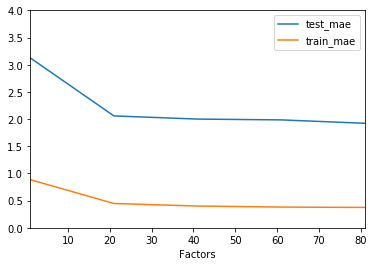

In [19]:
results_df = pd.DataFrame({'Factors': factors, 'test_mae': test_maes, 'train_mae': train_maes})
results_df.plot(x='Factors', y=['test_mae', 'train_mae'], ylim=(0,4))

In [21]:
# Grid searching for best iterations/epochs
iterations = np.arange(1,50,10)
test_maes = []
train_maes = []
for iteration in iterations:
    test_mae_mean, test_rmse_mean, train_mae_mean, train_rmse_mean = CV_nmf(data, factors=10, iterations=iteration)
    test_maes.append(test_mae_mean)
    train_maes.append(train_mae_mean)

Results of fold 0
Test MAE 2.33847964536
Test RMSE 3.29466027828
Train MAE 1.0972159179
Train RMSE 1.43336751174
Results of fold 1
Test MAE 2.3502177285
Test RMSE 3.32007473642
Train MAE 1.0863888976
Train RMSE 1.41744325701
Results of fold 2
Test MAE 2.37975167056
Test RMSE 3.32123942958
Train MAE 1.08143049941
Train RMSE 1.41316637344
Results of fold 3
Test MAE 2.31903265159
Test RMSE 3.24690579237
Train MAE 1.08380263918
Train RMSE 1.4177775971
Results of fold 4
Test MAE 2.35194558236
Test RMSE 3.30019548408
Train MAE 1.0875343399
Train RMSE 1.41309233746
----------Average of metrics------------
Average Test MAE 2.34788545568
Average Test RMSE 3.29661514415
Average Train MAE 1.0872744588
Average Train RMSE 1.41896941535
Results of fold 0
Test MAE 2.14884466312
Test RMSE 3.09535836215
Train MAE 0.502180098472
Train RMSE 0.776466957197
Results of fold 1
Test MAE 2.1029972857
Test RMSE 3.09063694938
Train MAE 0.511150780588
Train RMSE 0.786407647508
Results of fold 2
Test MAE 2.1783971

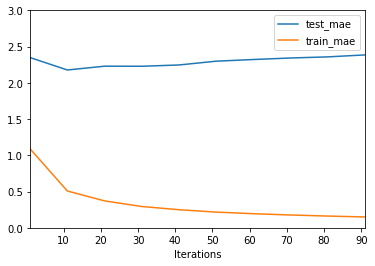

In [22]:
results_df = pd.DataFrame({'Iterations': iterations, 'test_mae': test_maes, 'train_mae': train_maes})
results_df.plot(x='Iterations', y=['test_mae', 'train_mae'], ylim=(0,3))

In [ ]:
test_maes = []
train_maes = []
for iteration in iterations:
    test_mae_mean, test_rmse_mean, train_mae_mean, train_rmse_mean = CV_nmf(data, factors=10, iterations=iteration)
    test_maes.append(test_mae_mean)
    train_maes.append(train_mae_mean)

In [67]:
# Time taken for different data sizes
import time
Num_users = [100, 150, 200, 300, 500]
times = []
test_maes = []
train_maes = []
for datas in datasets:
    time_start = time.time()
    test_mae_mean, test_rmse_mean, train_mae_mean, train_rmse_mean = CV_nmf(datas, factors=20, iterations=10)
    time_taken = time.time()-time_start
    times.append(time_taken)
    test_maes.append(test_mae_mean)
    train_maes.append(train_mae_mean)

Results of fold 0
Test MAE 2.2913284441
Test RMSE 3.33980632262
Train MAE 0.339019674761
Train RMSE 0.566084762553
Results of fold 1
Test MAE 2.3564721117
Test RMSE 3.42047137005
Train MAE 0.335932360844
Train RMSE 0.558467413512
Results of fold 2
Test MAE 2.38573934893
Test RMSE 3.48439505845
Train MAE 0.335394738499
Train RMSE 0.57137688815
Results of fold 3
Test MAE 2.35593729747
Test RMSE 3.44014032721
Train MAE 0.332041618681
Train RMSE 0.558050219915
Results of fold 4
Test MAE 2.2381612308
Test RMSE 3.30657784115
Train MAE 0.333881592091
Train RMSE 0.556898057055
----------Average of metrics------------
Average Test MAE 2.3255276866
Average Test RMSE 3.3982781839
Average Train MAE 0.335253996975
Average Train RMSE 0.562175468237
Results of fold 0
Test MAE 2.28555997439
Test RMSE 3.36332934329
Train MAE 0.381778394877
Train RMSE 0.618755159324
Results of fold 1
Test MAE 2.186172645
Test RMSE 3.21588837776
Train MAE 0.389358297163
Train RMSE 0.634204774503
Results of fold 2
Test MA

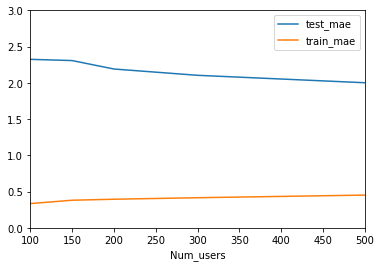

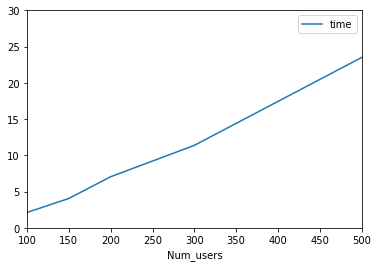

In [71]:
results_df = pd.DataFrame({'Num_users': Num_users, 'test_mae': test_maes, 'train_mae': train_maes, 'time': times})
results_df.plot(x='Num_users', y=['test_mae', 'train_mae'], ylim=(0,3))
results_df.plot(x='Num_users', y=['time'], ylim=(0,30))